import packages

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import warnings

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium

# adding 'custom script' 
#Ensure the [Pyeto](https://github.com/woodcrafty/PyETo) package is present in your 
# "C:\Users\{USERNAME}\anaconda3\envs\{ENVIRONMENT}\Lib\",or "C:\Users\{USERNAME}\anaconda3\Lib\",
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

from scipy.optimize import root

warnings.simplefilter('ignore')

add some useful paths to navigate shared storage:

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

add some spatial data

In [3]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")
all_rivers_bf = gpd.read_file(f"{gis_folder}\\all_river_in_volta_basin_bf.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))
all_rivers_bf = all_rivers_bf.set_geometry(all_rivers_bf.geometry.to_crs('EPSG:4326'))

gdf_precip = gpd.read_file('precipitation_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client = gpd.read_file('discharge_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client['name'] = gdf_discharge_client.apply(lambda x: x['name'].split(",")[-1][:-4].strip().lower(),axis=1)

In [4]:
gdf_discharge_client

,name,lat,lon,geometry
0,vonkoro,9.171205,-2.744841,POINT (-2.74484 9.17121)
1,dan,10.867876,-3.722479,POINT (-3.72248 10.86788)
2,samandeni,11.458715,-4.469477,POINT (-4.46948 11.45872)
3,dapola,10.572862,-2.914135,POINT (-2.91413 10.57286)
4,yakala,11.344608,-0.528965,POINT (-0.52897 11.34461)
5,yilou,12.999710,-1.570603,POINT (-1.57060 12.99971)
6,dakaye,11.777456,-1.600156,POINT (-1.60016 11.77746)
7,porga,11.045433,0.959914,POINT (0.95991 11.04543)
8,samboali,11.279537,1.015889,POINT (1.01589 11.27954)


# make general:

#### load precipitation data from analysis

In [5]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall.xlsx",index_col=0)
Rainfall_BF_msum.columns

Index(['Ouagadougou', 'Nakambe', 'Black_Volta', 'Mouhoun', 'Lake_Volta', 'Oti',
       'Penjari'],
      dtype='object')

#### load discharge data from analysis

In [6]:
names = ['black volta, vonkoro',
         'bougouriba, dan',
         'mou houn, black volta, samandeni',
         'mou houn, black volta,dapola',
         'nakanbe, white volta, yakala',
         'nakanbe, white volta, yilou',
         'nazinon, red volta, dakaye',
         'pendjari, porga',
         'singou, samboali']

need a dictionary to link discharge to precipitation stations

In [7]:
q_p_linking_dictionary = {'black volta, vonkoro': 'Black_Volta',
                          'bougouriba, dan': 'Mouhoun',
                          'mou houn, black volta, samandeni': 'Mouhoun',
                          'mou houn, black volta,dapola': 'Black_Volta',
                          'nakanbe, white volta, yakala': 'Nakambe',
                          'nakanbe, white volta, yilou': 'Nakambe',
                          'nazinon, red volta, dakaye': 'Nakambe',
                          'pendjari, porga': 'Penjari',
                          'singou, samboali': 'Penjari'}

In [8]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

## E

historic temperature data downloaded from [CMIP6](https://storage.googleapis.com/cmip6/pangeo-cmip6.json) model from NOAA-GFDL - 

In [9]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\daily_Near-Surface-Air-Temperature.xlsx",
# df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                       index_col=0, parse_dates=True)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
df_temperature_msum = df_temperature.resample('M').mean()

`dakaye` was chosen to as fairly centrally located

In [10]:
lat = deg2rad(gdf_discharge_client[gdf_discharge_client['name']=="dakaye"].iloc[0].geometry.y)

In [11]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

# some function

In [12]:
def plot_combined_df(combined_df):    
    """Plots the combined_dfs constructed"""
    fig, ax = plt.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("$m^3/month$")
    for val in ["P","Q","E"]:
        combined_df[val].plot(marker='.',lw=0.5, ax=ax,label=val)

    combined_df["Diff"].plot(ax=ax,label="Difference")
    ax.get_xlim()
    ax.set_title(f"Water balance")
    ax.legend()
    ax.axhline(0, alpha=0.2, ls="--", color="C4" )

In [13]:
FACTOR_EA_EP = 0.2726

In [14]:
output_river = all_rivers_bf.copy()

# now run per river segment:

In [40]:
for index, row in all_rivers_bf.iterrows():
    # get the centre of each segment
    centre = row.geometry.centroid
    # find nearest precipitation station:
    closest_station_index = gdf_precip.distance(centre).argmin()
    name_of_closest_station = gdf_precip.loc[closest_station_index, "name"]
    selected_rain_data = Rainfall_BF_msum[[name_of_closest_station]].rename(columns={name_of_closest_station:"P"})
    
    #prepare evaporation data
    df_temperature_msum.rename(columns={'evap':'E'},inplace=True)
    area_basin = row.UPLAND_SKM * 10**6
    
    # adjust potential to actuall evaporation
    combined_df = area_basin * FACTOR_EA_EP * df_temperature_msum[["E"]].copy()
    # combine everything:
    combined_df["P"] = selected_rain_data["P"] * area_basin
    combined_df["Q"] = combined_df["P"] - combined_df["E"]
    combined_df = combined_df.loc[combined_df.P.dropna().index]
    combined_df = combined_df[combined_df["Q"] >= 0]
    combined_df = combined_df.resample('M').mean()
#     combined_df['Q_ms'] = combined_df.apply(lambda x: x.Q / (x.name.days_in_month * 24 * 3600), axis=1)
#     combined_df["Q"].plot(marker='.', lw=1)
    
    output_river.loc[index,"MIN_1981_2014_M3"]   = combined_df['Q'].min()
    output_river.loc[index,"MAX_1981_2014_M3"]   = combined_df['Q'].max()
    output_river.loc[index,"MEAN_1981_2014_M3"]  = combined_df['Q'].mean()
    

In [41]:
output_river

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry,MIN_1981_2014_M3,MAX_1981_2014_M3,MEAN_1981_2014_M3,MIN_1981_2014_M3_s,MAX_1981_2014_M3_s,MEAN_1981_2014_M3_s
0,10482758,10483017,10821582,2.43,1763.0,9.5,15.19,15.2,0,0.002,...,6,9,1121891670,"LINESTRING (-2.41667 14.26458, -2.42292 14.264...",3.209353e+06,3.978544e+09,1.489383e+09,1.198235,1485.417997,561.263256
1,10482902,10482251,10821582,6.24,1742.0,38.7,20.59,308.2,0,0.043,...,4,8,1120649940,"LINESTRING (-2.52708 14.24792, -2.52292 14.252...",6.507385e+07,8.067021e+10,3.019920e+10,24.295792,30118.804377,11380.351029
2,10483016,10482902,10821582,2.22,1748.2,6.4,14.36,14.4,0,0.002,...,5,9,1120649940,"LINESTRING (-2.50833 14.24375, -2.51875 14.243...",3.040439e+06,3.769147e+09,1.410994e+09,1.135170,1407.238102,531.723085
3,10483017,10483386,10821582,1.74,1761.4,17.1,3.95,74.7,0,0.013,...,5,8,1121891670,"LINESTRING (-2.43125 14.25208, -2.43542 14.252...",1.577228e+07,1.955245e+10,7.319534e+09,5.888695,7300.047654,2758.313504
4,10483385,10483652,10821582,2.73,1758.8,9.1,12.69,12.7,0,0.002,...,6,9,1121891670,"LINESTRING (-2.46458 14.25417, -2.46458 14.239...",2.681499e+06,3.324178e+09,1.244419e+09,1.001157,1241.105826,468.950221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8214,10643665,10644351,10821582,3.56,973.8,7.6,32.79,32.8,0,0.209,...,3,7,1120827640,"LINESTRING (-2.97083 9.71458, -2.96458 9.71458...",4.753221e+06,1.103568e+10,3.003574e+09,1.774649,4120.251782,1135.845989
8215,10644351,10644352,10821582,2.60,971.2,10.2,5.71,49.5,0,0.316,...,3,7,1120827640,"LINESTRING (-2.95208 9.69375, -2.93542 9.67708)",7.173306e+06,1.665446e+10,4.532833e+09,2.678205,6218.062902,1714.157819
8216,10644352,10641971,10821582,13.43,957.8,23.6,71.52,144.1,0,0.927,...,3,7,1120827640,"LINESTRING (-2.93542 9.67708, -2.92292 9.67708...",2.088229e+07,4.848298e+10,1.319558e+10,7.796554,18101.472004,4990.103874
8217,10645063,10644352,10821582,2.93,971.2,8.0,23.07,23.1,0,0.147,...,4,7,1120827640,"LINESTRING (-2.95417 9.65833, -2.93542 9.67708)",3.347543e+06,7.772081e+09,2.115322e+09,1.249829,2901.762688,799.940316


Text(0, 12.5, '< 2e+10m$^3$/month')

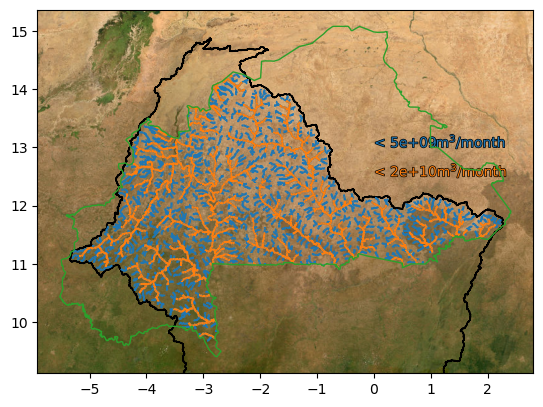

In [42]:
fig,ax = plt.subplots(1)
country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)
bounds= (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
# add background
with rasterio.open(get_background_map("rivers", bounds)) as r:
    rioshow(r, ax=ax)
    
ax.set_xlim(bounds[0],bounds[2])
ax.set_ylim(bounds[1],bounds[3])
stats = output_river["MEAN_1981_2014_M3"].describe()
output_river[output_river["MEAN_1981_2014_M3"]>stats[f'50%']].plot(ax=ax,color=f'C0')
ax.annotate(f"< {stats[f'50%']:.1g}m$^3$/month", (0,13),color='C0',
           path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground="k")])
output_river[output_river["MEAN_1981_2014_M3"]>stats[f'75%']].plot(ax=ax,color=f'C1')
ax.annotate(f"< {stats[f'75%']:.1g}m$^3$/month", (0,12.5),color='C1',
           path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground="k")])
    

In [20]:
output = True
if output:
    output_river.to_file(f"{gis_folder}\\all_river_in_volta_basin_bf_with_Q.gpkg",crs="epsg:4326")